In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
from sklearn.metrics import normalized_mutual_info_score as nmis

from IPython.display import SVG, display, Image
def show_svg(file):
    display(SVG(filename=file))

# Formato para matplotlib
from matplotlib import rcParams
%matplotlib inline
rcParams['font.family'] = 'serif'
rcParams['axes.labelsize'] = 40
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 150
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'

try:
    from community import community_louvain as louvain
except ModuleNotFoundError:
    !pip install python-louvain -q
    from community import community_louvain as louvain

try:
    import igraph as ig
except ModuleNotFoundError:
    !pip install igraph -q
    import igraph as ig

try:
    import bbox
except ModuleNotFoundError:
    !pip install bbox -q
    import bbox

# 1)

Cargamos la red de delfines. Agregamos el sexo de cada delfín a los nodos por si es de utilidad más adelante.

In [2]:
dolphins = nx.read_gml('datasets/dolphins.gml')
genders = pd.read_csv("datasets/dolphinsGender.txt",
                          delimiter = "\t", header = None, names = ["ID", "Gender"])
genders.set_index("ID", inplace = True)
genders = pd.Series(genders["Gender"])

# Agregamos el atributo de sexo a cada nodo
for i in dolphins.nodes:
    dolphins.nodes[i]["Gender"] = genders[i]
# Se puede acceder al genero de cada delfin como dolphins.nodes[ID]["Gender"]

dolphins_ig = ig.Graph.from_networkx(dolphins) # Versión de igraph de la red.

## a) Cálculo de comunidades

In [3]:
#Calculo de comunidades con distintas metodologías.
com_im = dolphins_ig.community_infomap()
com_lv = louvain.best_partition(dolphins)
com_bt = dolphins_ig.community_edge_betweenness(clusters = None, directed = False, weights = None)
com_fg = dolphins_ig.community_fastgreedy(weights = None)

Graficamos los resultados obtenidos

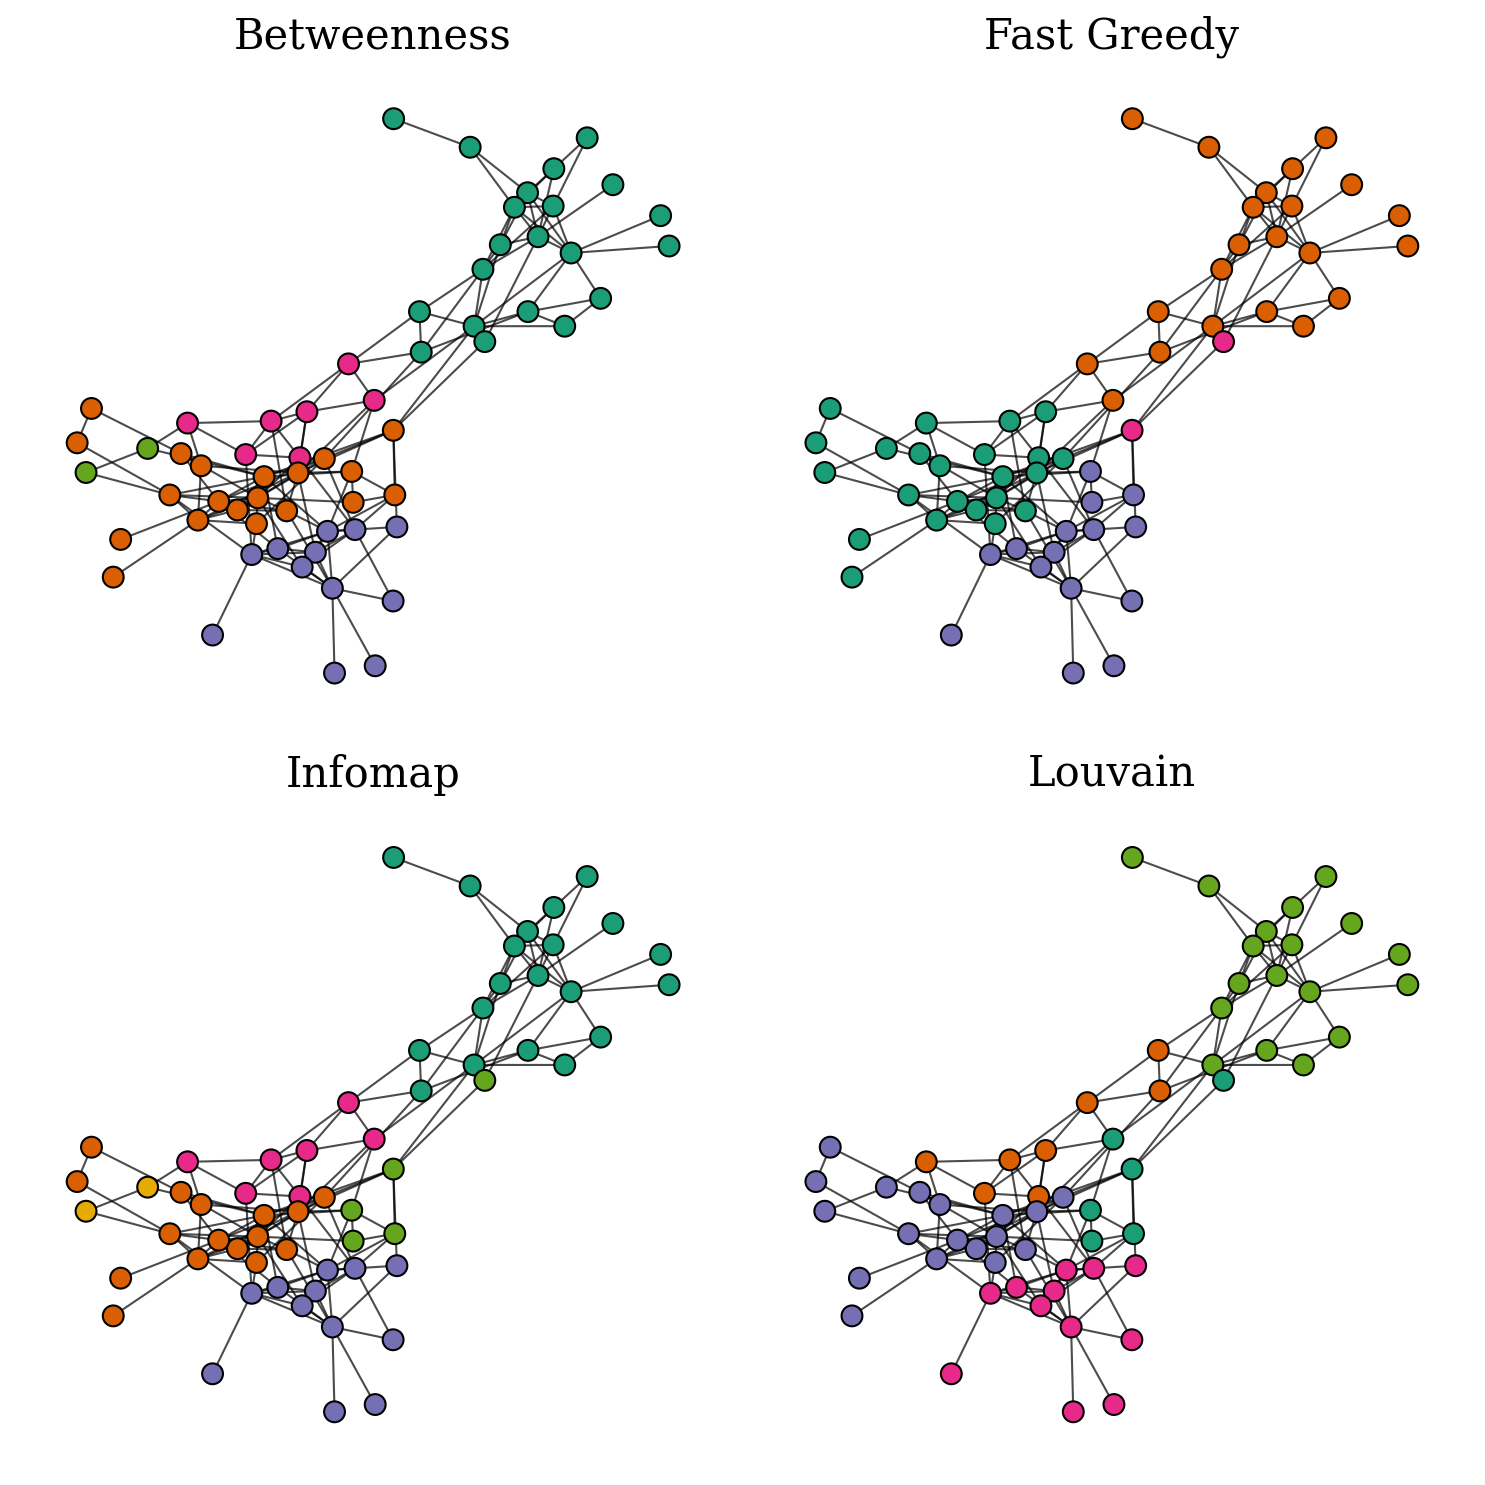

In [20]:
def cluster_to_dict(clusters, G) -> dict:
    """
    Arma un diccionario con los nombres de los nodos
    como keys y el id del cluster como valor.
    """
    dic = {}
    for i, cluster in enumerate(sorted(list(clusters), key = len, reverse = True)):
        for node in cluster:
            dic[G.vs[node]['_nx_name']] = i
    return dic

# Formato custom de ploteo de grafos.
CUSTOM_FORMAT = {"node_size": 100, "edgecolors": "black",
                "linewidths": 1}

dic_com_bt = cluster_to_dict(com_bt.as_clustering(), dolphins_ig)
dic_com_fg = cluster_to_dict(com_fg.as_clustering(), dolphins_ig)
dic_com_im = cluster_to_dict(com_im, dolphins_ig)
particiones = {"Betweenness": dic_com_bt, "Fast Greedy": dic_com_fg, 
               "Infomap": dic_com_im, "Louvain": com_lv
               }

#Plot de la red coloreando según la comunidad en la que se encuentra.
fig, axs = plt.subplots(2, 2, figsize = (10, 10), tight_layout=True)
pos = nx.layout.fruchterman_reingold_layout(dolphins)

for i, ax in enumerate(fig.axes):
    nx.draw_networkx_nodes(dolphins,
                           pos = pos,
                           node_color = [plt.get_cmap('Dark2')(list(particiones.values())[i][v]) for v in dolphins.nodes()],
                           ax = ax,
                           **CUSTOM_FORMAT)
    nx.draw_networkx_edges(dolphins,
                           pos = pos,
                           ax = ax,
                           alpha = .7)
    ax.set_title(f"{list(particiones.keys())[i]}", fontsize=20)
    ax.axis('off')

plt.show()


## b) Caracterización de la partición obtenida.

Graficamos el _Silhoutte Score_ de las particiones obtenidas por cada método.

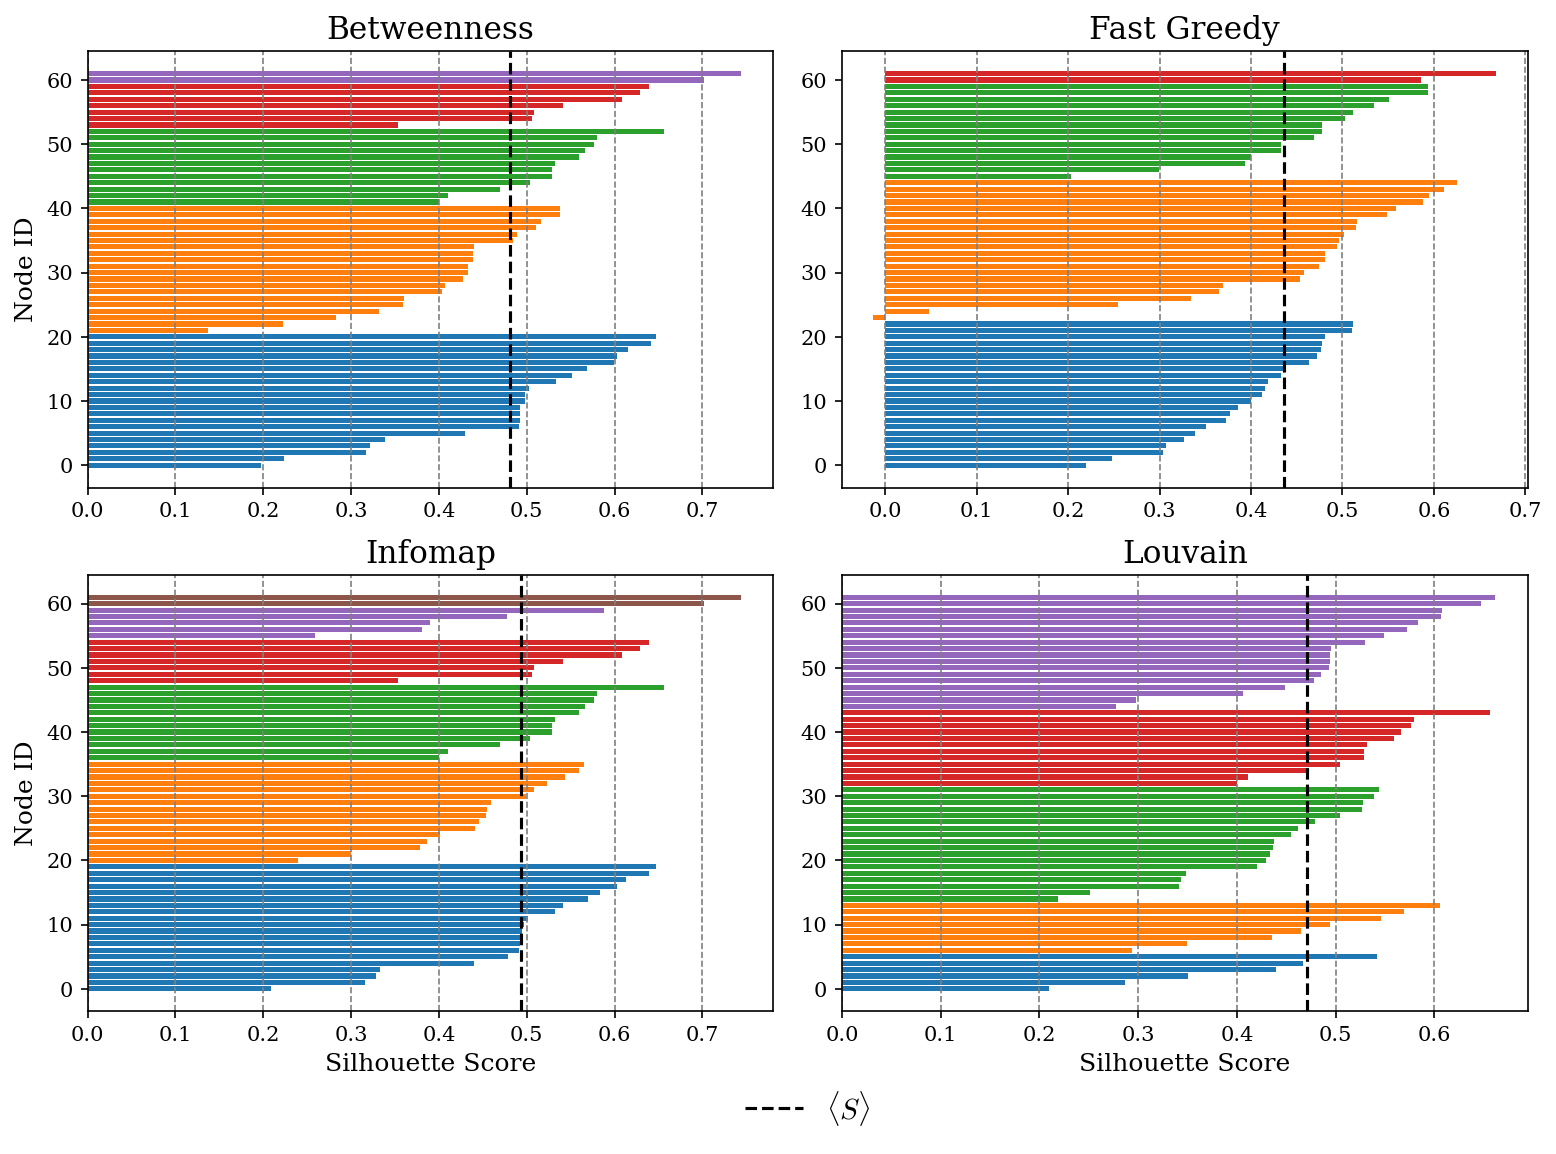

In [46]:
def silhouette(Red, particion, ax = None, PLOT = True): 
	"""
	Grafica el 'Silhoutte score' de la partición obtenida, 
	junto con el valor medio de S.
	"""

	S=[]
	limites=[0]

	#Iteramos sobre cada cluster obtenido de la partición.
	for cluster in set(particion.values()): 
		nodos_en_cluster = [nodo for (nodo, value) in particion.items() if value == cluster] 
		S_cluster=[]

		for nodo in nodos_en_cluster:
			distancias_dentro=[]
			distancias_fuera=[]

			#Calculamos la distancia del nodo a todos los nodos en el cluster.
			for nodo_en_cluster in nodos_en_cluster:
				if nodo != nodo_en_cluster:
					distancias_dentro.append(nx.shortest_path_length(Red, 
																	 source=nodo, 
																	 target=nodo_en_cluster, 
																	 weight=None))

			#Calculamos la distancia del nodo a todos los nodos fuera del cluster.
			for nodo_fuera in Red.nodes():
				if particion[nodo_fuera] != cluster:
						distancias_fuera.append(nx.shortest_path_length(Red, 
																		source=nodo, 
																		target=nodo_fuera, 
																		weight=None)) 
				
			#Calculamos valores medios.
			distancia_media_dentro = np.mean(distancias_dentro)
			distancia_mean_fuera = np.mean(distancias_fuera)

			#Y finalmente guardamos el valor de S para ese cluster.
			S_cluster.append((distancia_mean_fuera - distancia_media_dentro) / \
							  np.max([distancia_mean_fuera,distancia_media_dentro]))

		S_cluster=sorted(S_cluster)
		limites.append(len(S_cluster)+limites[-1])
		S = S + S_cluster

	S = np.array(S)
	S_media = np.mean(S[~np.isnan(S)])

	if PLOT:
		for i in range(len(limites)-1):
			ax.barh(range(limites[i],limites[i+1]), S[limites[i]:limites[i+1]])
		ax.axvline(S_media, ls="--", color="black", label = r"$\langle S \rangle$")

	return S, S_media

#Creamos las figuras
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

#Graficamos el Silhouette score para cada método.
dolphins_Ss = {}
for i, (methodname, particion) in enumerate(particiones.items()):
    s, s_media = silhouette(dolphins, particion, axs[i])
    axs[i].set_title(methodname, fontsize=15)
    axs[i].grid(ls="--", color="gray", axis="x")
    dolphins_Ss[methodname] = s_media

axs[2].set_xlabel("Silhouette Score", fontsize=12)
axs[3].set_xlabel("Silhouette Score", fontsize=12)
axs[0].set_ylabel("Node ID", fontsize=12)
axs[2].set_ylabel("Node ID", fontsize=12)
axs[2].legend(frameon=False, bbox_to_anchor=(1.05, -0.15), loc="upper center", fontsize = 14, borderaxespad=0)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.2)
plt.show()

Veamos también la modularidad de las particiones obtenidas con cada método:

In [42]:
Q_bt = com_bt.as_clustering().modularity #Betweenness
Q_fg = com_fg.as_clustering().modularity #Fast Greedy
Q_im = com_im.modularity #Infomap
Q_lv = louvain.modularity(com_lv, dolphins) #Louvain

dolphins_Qs = {"Betweenness": Q_bt, "Fast Greedy": Q_fg, "Infomap": Q_im, "Louvain": Q_lv}

print(f"La modularidad utilizando el método de 'Betweenness' es: {Q_bt:.3g}")
print(f"La modularidad utilizando el método de 'Fast Greedy' es: {Q_fg:.3g}")
print(f"La modularidad utilizando el método de 'Infomap' es: {Q_im:.3g}")
print(f"La modularidad utilizando el método de 'Louvain' es: {Q_lv:.3g}")

La modularidad utilizando el método de 'Betweenness' es: 0.519
La modularidad utilizando el método de 'Fast Greedy' es: 0.495
La modularidad utilizando el método de 'Infomap' es: 0.525
La modularidad utilizando el método de 'Louvain' es: 0.519


Podemos recablear las redes y ver como varía la modularidad.

In [43]:
def modularity_from_random(G: nx.Graph, seed=42) -> dict:
    """
    Calcula la modularidad con distintos metodos para una red G recableada.
    """
    
    random_G = nx.random_reference(G, seed=seed, connectivity=True, )
    random_G_ig = ig.Graph.from_networkx(random_G) # Versión de igraph de la red.    
    com_im = random_G_ig.community_infomap()
    com_lv = louvain.best_partition(random_G)
    com_bt = random_G_ig.community_edge_betweenness(clusters = None, directed = False, weights = None)
    com_fg = random_G_ig.community_fastgreedy(weights = None)

    Q_bt = com_bt.as_clustering().modularity #Betweenness
    Q_fg = com_fg.as_clustering().modularity #Fast Greedy
    Q_im = com_im.modularity #Infomap
    Q_lv = louvain.modularity(com_lv, random_G) #Louvain
    
    return {"Betweenness": Q_bt, "Fast Greedy": Q_fg, "Infomap": Q_im, "Louvain": Q_lv}

try:
    df_Q = pd.read_csv("Random Q vals.csv")
    df_Q.drop("Unnamed: 0", inplace=True, axis=1)
except FileNotFoundError:
    Q_vals = []
    for i in tqdm(range(1000)):
        Q_vals.append(modularity_from_random(dolphins, seed=i))
       
    df_Q = pd.DataFrame(Q_vals) 
    df_Q.to_csv("Random Q vals.csv")

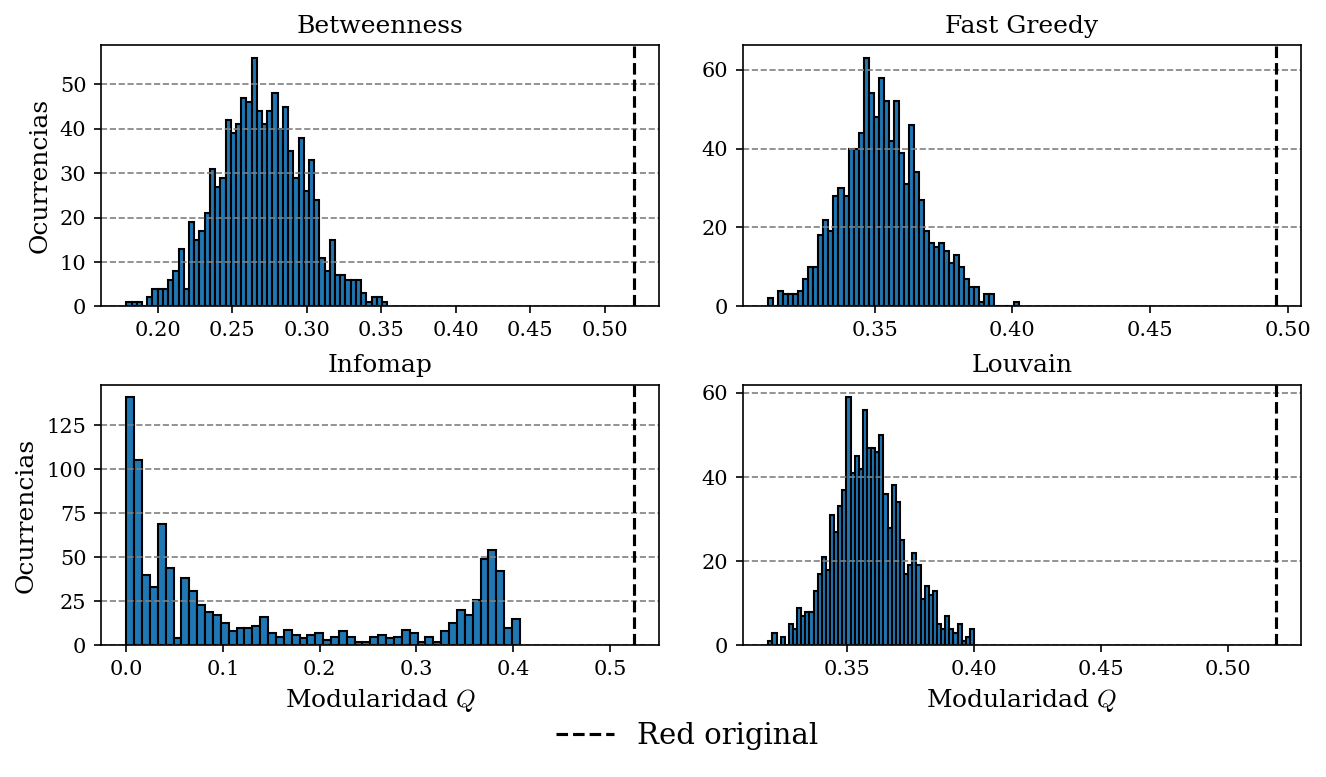

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs = axs.flatten()

for i, c in enumerate(df_Q.columns):
    axs[i].hist(df_Q[c], bins = 50, edgecolor="black")
    axs[i].set_title(c)
    axs[i].axvline(dolphins_Qs[c], ls="--", color="black", label="Red original")
    axs[i].grid(axis="y", color="gray", ls="--")

axs[2].legend(frameon=False, bbox_to_anchor=(1.05, -0.25), loc="upper center", fontsize = 14, borderaxespad=0)

axs[0].set_ylabel(r"Ocurrencias")
axs[2].set_ylabel(r"Ocurrencias")
axs[2].set_xlabel(r"Modularidad $Q$")
axs[3].set_xlabel(r"Modularidad $Q$")

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.15,
                    hspace=0.3)
plt.show()

Al analizar la distribución de la modularidad para cada método, se logran reforzar algúnas intuiciones sobre el funcionamiento de los algoritmos de cómputo de modularidad. En particular, se observa que la distribucion obtenidas para Infomap no es normal, lo que indica que su resultado depende en cierto modo de la distribución de grado de la red.

Dicho esto, la modularidad obtenida para la red original difiere significativamente de las obtenidas con las redes recableadas.

Repitiendo el análisis de recableado para el valor medio de $S$:

In [51]:
def S_from_random(G: nx.Graph, seed=42) -> dict:
    """
    Calcula la modularidad con distintos metodos para una red G recableada.
    """
    
    random_G = nx.random_reference(G, seed=seed, connectivity=True, )
    random_G_ig = ig.Graph.from_networkx(random_G) # Versión de igraph de la red.    

    com_im = random_G_ig.community_infomap()
    com_bt = random_G_ig.community_edge_betweenness(clusters = None, directed = False, weights = None)
    com_fg = random_G_ig.community_fastgreedy(weights = None)

    dic_com_lv = louvain.best_partition(random_G)
    dic_com_bt = cluster_to_dict(com_bt.as_clustering(), random_G_ig)
    dic_com_fg = cluster_to_dict(com_fg.as_clustering(), random_G_ig)
    dic_com_im = cluster_to_dict(com_im, random_G_ig)

    _, S_med_bt = silhouette(random_G, dic_com_bt, PLOT=False)
    _, S_med_fg = silhouette(random_G, dic_com_fg, PLOT=False)
    _, S_med_im = silhouette(random_G, dic_com_im, PLOT=False)
    _, S_med_lv = silhouette(random_G, dic_com_lv, PLOT=False)

    return {"Betweenness": S_med_bt, "Fast Greedy": S_med_fg, "Infomap": S_med_im, "Louvain": S_med_lv}

try:
    df_S = pd.read_csv("Random S vals.csv")
    df_S.drop("Unnamed: 0", inplace=True, axis=1)
except FileNotFoundError:
    S_vals = []
    for i in tqdm(range(1000)):
        S_vals.append(S_from_random(dolphins, seed=i+1))
    df_S = pd.DataFrame(S_vals) 
    df_S.to_csv("Random S vals.csv")

100%|██████████| 1000/1000 [06:21<00:00,  2.62it/s]


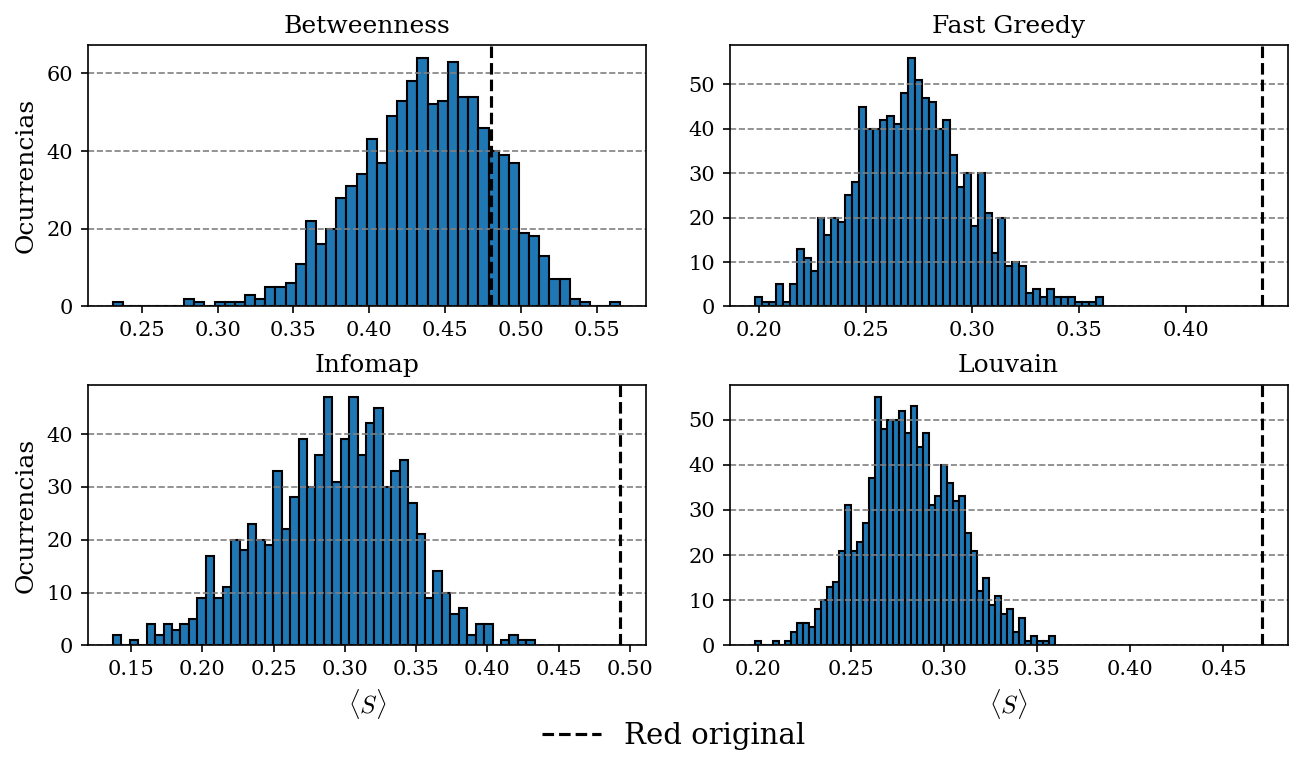

In [52]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs = axs.flatten()

for i, c in enumerate(df_S.columns):
    axs[i].hist(df_S[c], bins = 50, edgecolor="black")
    axs[i].set_title(c)
    axs[i].axvline(dolphins_Ss[c], ls="--", color="black", label="Red original")
    axs[i].grid(axis="y", color="gray", ls="--")

axs[2].legend(frameon=False, bbox_to_anchor=(1.05, -0.25), loc="upper center", fontsize = 14, borderaxespad=0)

axs[0].set_ylabel(r"Ocurrencias")
axs[2].set_ylabel(r"Ocurrencias")
axs[2].set_xlabel(r"$\langle S \rangle$")
axs[3].set_xlabel(r"$\langle S \rangle$")

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.15,
                    hspace=0.3)
plt.show()

## c)

In [35]:
# Comparamos usando información mutua normalizada.
pairs = sorted(list(set(tuple(sorted([p1, p2])) for p1 in particiones for p2 in particiones)))
for p1, p2 in pairs:
    if p1 != p2:
        print(f"NMIS{p1, p2} =",nmis([particiones[p1][n] for n in dolphins.nodes()],
            [particiones[p2][n] for n in dolphins.nodes()]))

NMIS('Betweenness', 'Fast greedy') = 0.6621479706254773
NMIS('Betweenness', 'Infomap') = 0.8730413056378089
NMIS('Betweenness', 'Louvain') = 0.7834028833139995
NMIS('Fast greedy', 'Infomap') = 0.7966214085140221
NMIS('Fast greedy', 'Louvain') = 0.7411220536771526
NMIS('Infomap', 'Louvain') = 0.9114029260932061


In [50]:
# Comparamos usando precisión.
def check_same_com(com):
    """
    Chequea que pares de nodos pertenecen a la misma comunidad.
    Devuelve un diccionario con llave (i, j) y valor True/False.
    """
    pairs = {}
    for n1, v1 in com.items():
        for n2, v2 in com.items():
            if n1 != n2:
                #Ordenamos para que cuando pase (n1, n2) o (n2, n1) no genere una nueva entrada.
                pairs[tuple(sorted([n1, n2]))] = True if v1 == v2 else False
    return pairs

def conf_matrix(coms_ref, coms_obj):
    """
    Calcula la matriz de confusión de dos pares de particiones.
    """
    ref_pairs = check_same_com(coms_ref)
    obs_pairs = check_same_com(coms_obj)

    a, b, c, d = 0, 0, 0, 0

    for rp, rv in ref_pairs.items():
        for op, ov in obs_pairs.items():
            if rp == op:
                if rv: #Ref: C(i) = C(j)
                    if ov: #Obj: C(i) = C(j)
                        a += 1
                    else: #Obj: C(i) != C(j)
                        c += 1
                else: #Ref: C(i) != C(j)
                    if ov: #Obj: C(i) = C(j)
                        b += 1
                    else: #Obj: C(i) != C(j)
                        d += 1

    return np.array([[a, b], [c, d]])

def precision(M):
    """
    Calcula la precisión a partir de una matriz de confusión
    """
    return (M[0, 0] + M[1, 1])/(M[0, 0] + M[1, 0] + M[0, 1] + M[1, 1])

# Comparamos usando información mutua normalizada.
pairs = sorted(list(set(tuple(sorted([p1, p2])) for p1 in particiones for p2 in particiones)))
for p1, p2 in pairs:
    if p1 != p2:
        print(f"Precisión{p1, p2} =",precision(conf_matrix(particiones[p1], particiones[p2])))

Precisión('Betweenness', 'Fast greedy') = 0.8434690639873083
Precisión('Betweenness', 'Infomap') = 0.9365415124272871
Precisión('Betweenness', 'Louvain') = 0.9053410893707033
Precisión('Fast greedy', 'Infomap') = 0.9037546271813856
Precisión('Fast greedy', 'Louvain') = 0.8799576943416182
Precisión('Infomap', 'Louvain') = 0.9687995769434162


## d)